# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

**Answer**: Then we should have to scale values of inputs at test time, since we want to get the ouputs of neurons at test time to be identical to the train time. Say we have an input of dropout and call it ***x***. The probability of values in x to be dropout is ***p***. Then the output of the dropout should be **px + (1-p) * 0 = px**. To get the same value at a test time, we have to scale the ***x*** with ***p***. This is why we want to divide with p when we are applying a dropout mask. 


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 1 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [4]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
Initial loss:  2.3004790897684924
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_

w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu

x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th l

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th l

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
b2 relative error: 2.09e-09
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 t

w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th l

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)

relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th l

2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th l

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th l

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)

x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th l

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed


x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th l

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_

w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now bein

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th l

x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_o

0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed


out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10

out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now bein

out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 

b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20

relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed


x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2

w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu

w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)
out (2, 10)
0 th layer now being processed
x (2, 15)
w (15, 20)
b (20,)
x_rs (2, 15)
out (2, 20)
relu_out (2, 20)
1 th layer now being processed
x (2, 20)
w (20, 30)
b (30,)
x_rs (2, 20)
out (2, 30)
relu_out (2, 30)
2 th layer now being processed
x (2, 30)
w (30, 10)
b (10,)
x_rs (2, 30)

# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [7]:
# Train two identical nets, one with dropout and one without
# Result : (without dropout) train acc: 0.994000; val_acc: 0.310000
#          (with dropout) train acc: 0.994000; val_acc: 0.305000
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
(Iteration 1 / 125) loss: 7.856644
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_ou

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now 

0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being processed
x (100, 500)
w (500, 10)
b (10,)
x_rs (100, 500)
out (100, 10)
0 th layer now being processed
x (100, 3072)
w (3072, 500)
b (500,)
x_rs (100, 3072)
out (100, 500)
relu_out (100, 500)
1 th layer now being pro

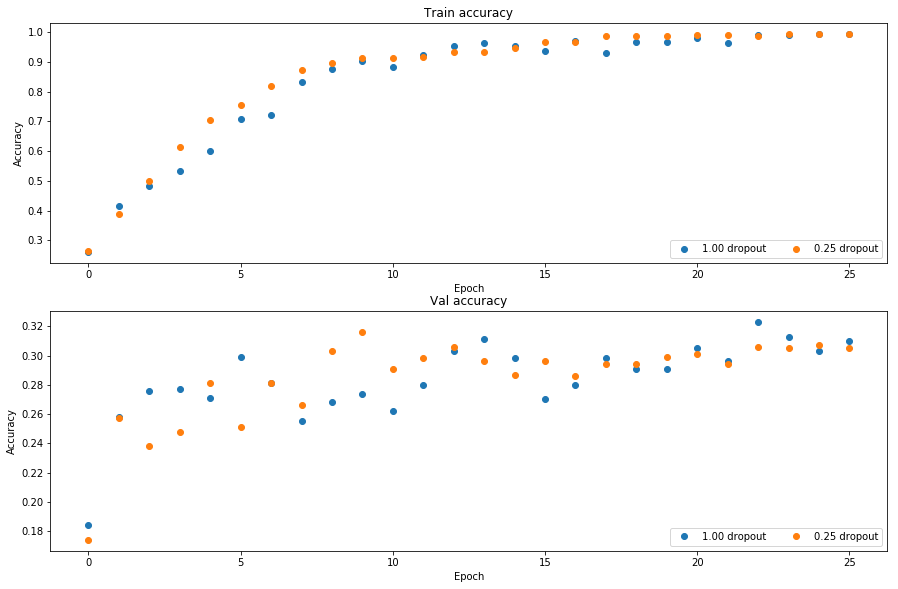

In [8]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

**Answer**: Even though the train accuracy was roughly the same for both of the cases, model with dropout tend to perform slightly better than the model without it due to the regularization effect of dropout.


## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

**Answer**: When we use dropout, we get the effect similar to ensemble, since we are using different data points per epoch. That means if we are to modify p after deciding to decrease the size of the hidden layers, we should decrease p. Plus, it would be helpful for us to increase the epoch size to get generalization effect of ensembling different dropout models.
